# Diagnosing and Predicting Coronary Artery Disease

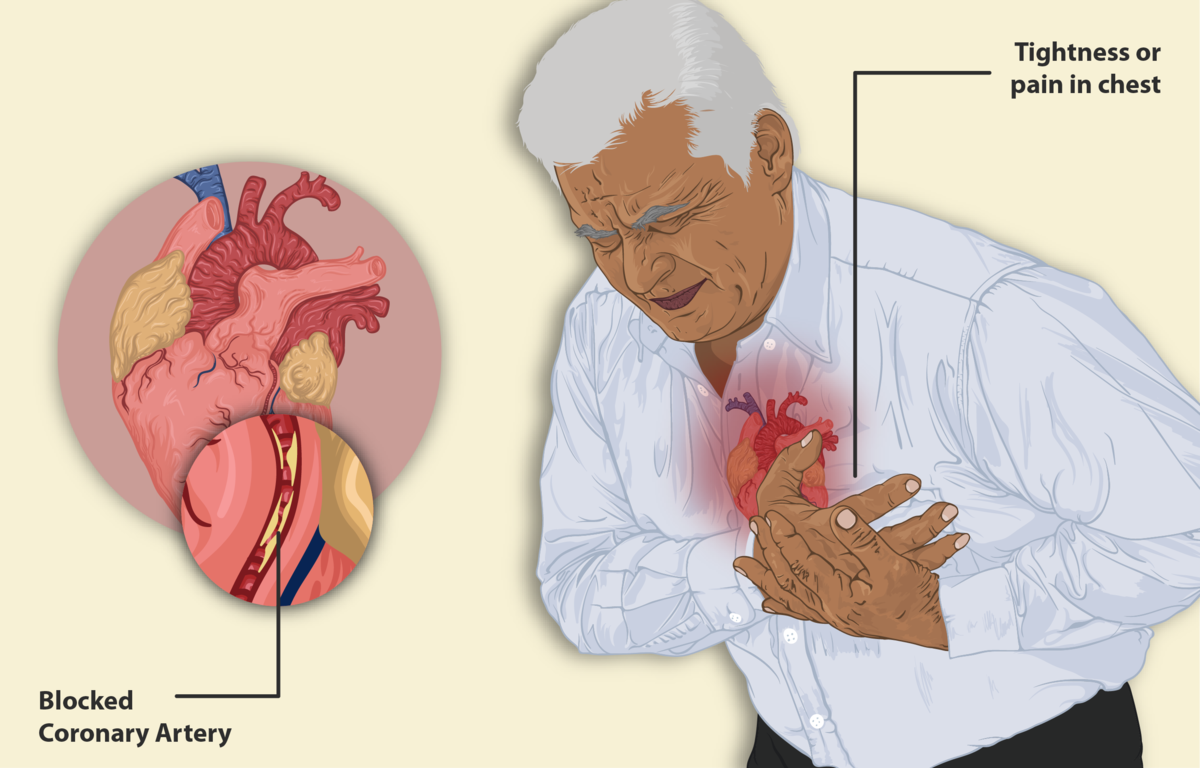

## Introduction: 

The coronary arteries are responsible for supplying the heart with sufficient blood, oxygen, and nutrients (Mayo Clinic, 2022). These arteries wrap around the heart to facilitate proper heart contraction and blood circulation (Sachdev, 2023).


Coronary Artery Disease (CAD) is a heart condition which occurs when the movement of blood through the coronary arteries gets restricted by the buildup of plaque on the inner walls of the coronary arteries. Plaque is a collection of different substances found in the blood - including cholesterol, fat, and calcium (Shahjehan & Bhutta, 2023). This blood flow obstruction can lead to angina, heart attacks, more complex cardiovascular diseases, reduced life expectancy and sudden death (Sachdev, 2023).


This CAD data analysis proposal outlines an approach to leverage data analysis techniques to develop an efficient predictive model to classify individuals based on whether they have CAD (or at risk of developing CAD) or not. 

### <center>What is the likelihood of a patient having CAD based on the number of major vessels, thalassemia health condition, maximum heart rate, and exercise-induced angina?</center>

## Methods    

The original data from Janosi et al. (1988) is a grouped dataset which contains observations from four different regions (Cleveland, Hungary, Switzerland, and California).

To develop a well-rounded and more accurate data interpretation/classifier, the four different regions will be combined into one dataframe. 

There will be 8 major steps in this data analysis: 

1. <u>*Reading the dataset*</u>:  
Read the four separate dataframes into R

2. <u>*Data merging and initial cleaning*</u>:  
Merge the four dataframes and create column headers. 

3. <u>*Data wrangling to create tidy data*</u>:  
Transform the merged dataset according to tinydata conditions and conventional formatting.

4. <u>*Predictor variables selection*</u>:  
Create a correlation plot to identify the 4 most num-predictor variable relationships.
These 4 will be the main focus in our classifier.  

6. <u>*Splitting into Training and Test Set*</u>:  
To wrangle and train the model then test it's performance independently. 

7. <u>*K-Nearest Neighbors classification*</u>:  
Set up knn classifier using cross-validation to find the optimal K value (# of nearest neighbors), then set up a workflow to start the model training process.

8. <u>*Effectiveness of the model*</u>:  
Using the testing set and graphs (predictions laid atop their true 'label'), evaluate the k-nn classifier performance. 

9. <u>*Analysis of the results*</u>



## Preliminary exploratory data analysis

### Loading libraries

In [7]:
# install.packages("ggcorrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [8]:
library(tidyverse)    # allows data manipulation and visualization 
library(tidymodels)    # allows modelling and statistical analysis 
library(repr)    # string and binary representations of objects 
library(ggplot2)    # creates complex graphics
library(purrr)    # tools for functional programming and iterating functions 
library(stringr)    # string manipulation functions 
library(RColorBrewer)    # provides color schemes for graphics among other uses  
options(repr.matrix.max.rows = 6)    # limits output of dataframes to 6 rows
library(ggcorrplot)    # imports the function to create the correlation plot

### Reading and Wrangling our dataset into Tidydata

In [9]:
# From the source (https://archive.ics.uci.edu/dataset/45/heart+disease), this is a grouped dataset which contains observations from Cleveland, Hungary,Switzerland, and California.

# read each of the 4 datasets 
# transform the merged dataset according to tinydata conditions  

data1 <- read.csv("data/heart_disease/processed.cleveland.data", header = FALSE) |> # setting header to false since the dataset does not specify any, I will manually add these later.  
    map_df(function(x) gsub("?", NA, x, fixed = TRUE)) #replacing "?" with "NA" values and turning “num” into a binomial classifier.
           
data2 <- read.csv("data/heart_disease/processed.hungarian.data", header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))
           
data3 <- read.csv("data/heart_disease/processed.switzerland.data", header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))
           
data4 <- read.csv("data/heart_disease/processed.va.data", header = FALSE) |> 
    map_df(function(x) gsub("?",NA,x, fixed = TRUE))

# There are a total of 14 columns in this dataset (Janosi et al., 1988): 
    # 1. age: age (years) 
    # 2. sex: sex (0 = female, 1 = male)
    # 3. cp: chest pain type (4 types)
    # 4. trestbps: resting blood pressure (mmHg)
    # 5. chol: serum cholestrol levels (mg/dl)
    # 6. fbs: fasting blood pressure (> or < 120mg/dl)
    # 7. restecg: resting electrocardiographic results
    # 8. thalach: maximum heart rate achieved
    # 9. exang: exercise-induced angina (0 = false, 1 = true)
    # 10. oldpeak: ST depression induced by exercise relative to rest
    # 11. slope: slope of peak exercise ST segment (1 = uplope, 2 = flat, 3 = downslope)
    # 12. ca: number of major vessels (0-3) colored by fluoroscopy)
    # 13. thal: thalassemia health condition level (3 = normal, 6 = fixed defect, 7 = reversable defect)
    # 14. num: diagnosis of the heart disease

# merge datasets into single dataset and change column header names to match the above list

heart_data <- 
    bind_rows(data1, data2, data3, data4) |>
    setNames(c("age", "sex", "cp", "trestbps", "chol", "fbs",
               "restecg", "thalach", "exang", "oldpeak", "slope", "ca",
               "thal", "num")) |>
    mutate_all(as.numeric) |>
    mutate(num = ifelse(num > 0, "presence", "no presence") |> as.factor())       

heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,no presence
67,1,4,160,286,0,2,108,1,1.5,2,3,3,presence
67,1,4,120,229,0,2,129,1,2.6,2,2,7,presence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,NA,NA,6,presence
58,1,4,NA,385,1,2,NA,NA,NA,NA,NA,NA,no presence
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,presence


### Splitting the data into a training and testing set 

In [10]:
# splitting the dataframe into a training_set (0.75) and a testing_set (0.25) 
set.seed(9999)

heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

heart_train
heart_test 

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,no presence
37,1,3,130,250,0,0,187,0,3.5,3,0,3,no presence
41,0,2,130,204,0,2,172,0,1.4,1,0,3,no presence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,1,4,158,170,0,1,138,1,0,NA,NA,NA,presence
54,0,4,127,333,1,1,154,0,0,NA,NA,NA,presence
55,1,4,122,223,1,1,100,0,0,NA,NA,6,presence


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3,3,presence
67,1,4,120,229,0,2,129,1,2.6,2,2,7,presence
56,1,2,120,236,0,0,178,0,0.8,1,0,3,no presence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,1,4,160,254,1,1,108,1,3,2,NA,NA,presence
46,1,4,134,310,0,0,126,0,0,NA,NA,3,presence
62,1,2,120,254,0,2,93,1,0,NA,NA,NA,presence


### Correlation Plot

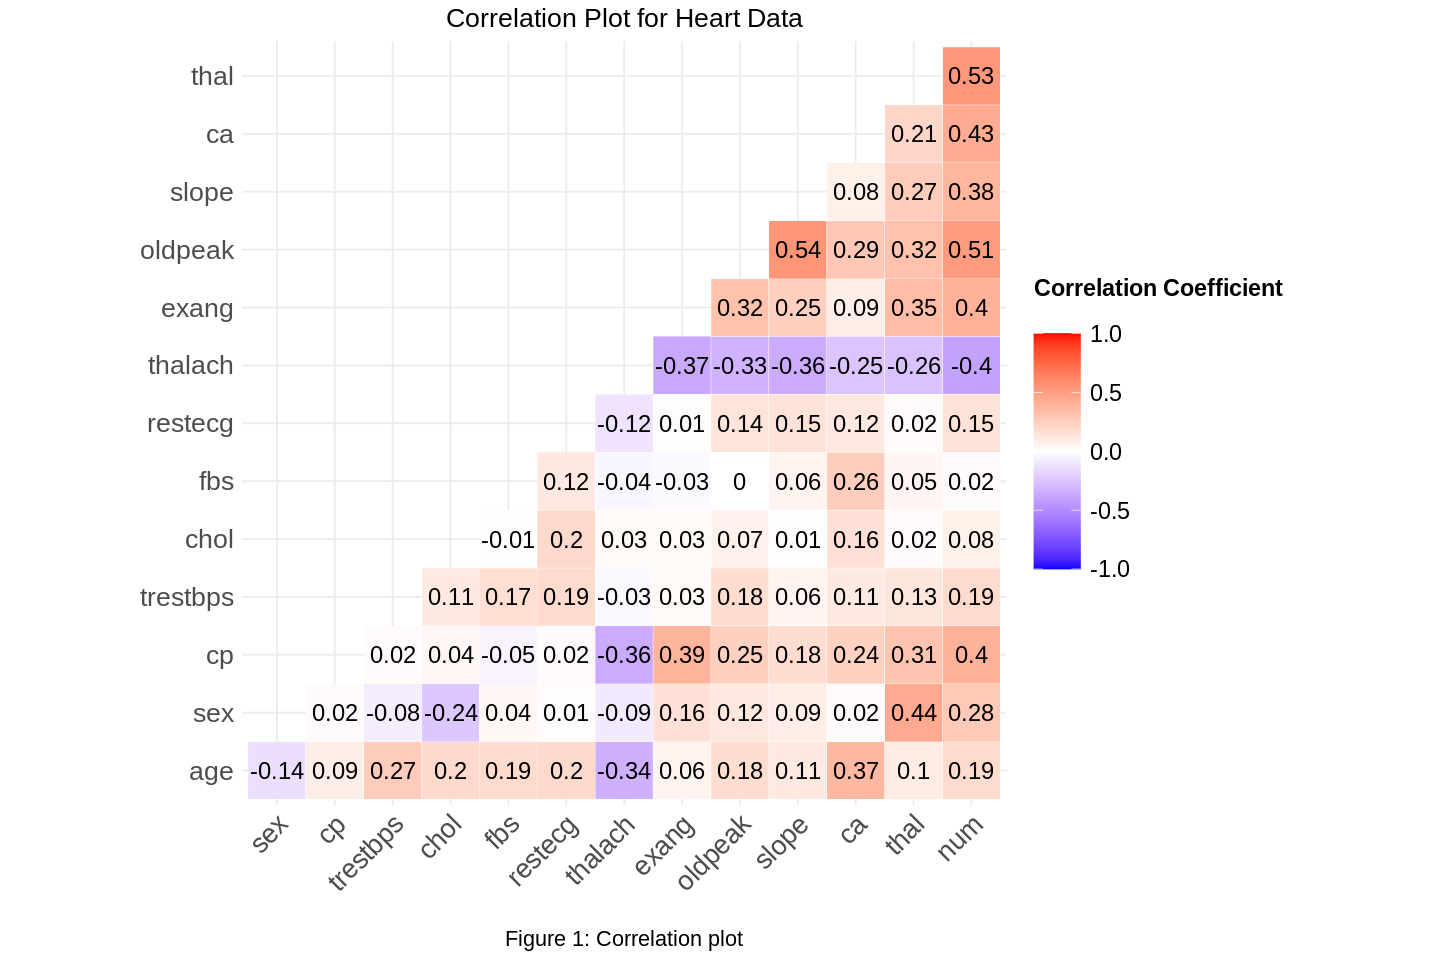

In [40]:
options(repr.plot.width = 12, repr.plot.height = 8)

# The R package corrplot is a tool which can help detect hidden patterns among variables 

corr_plot <- 
    heart_train |>
    mutate(num = ifelse(num == "presence", TRUE, FALSE) |> as.numeric()) |>       # ensuring the data is suitable for modelling (pre-processing step) 
    cor(use="complete.obs") |>  # skips NA value rows
    ggcorrplot(outline.col = "white",      # formatting the correlation plot 
               type = "lower",
               lab = TRUE,
               lab_size = 5,
               tl.cex = 16,
               legend.title = "Correlation Coefficient\n") +
    labs(title = "Correlation Plot for Heart Data",
         caption = "\nFigure 1: Correlation plot") +
    theme(legend.title = element_text(size = 14, face = "bold"),       # formatting the correlation plot
          legend.text = element_text(size = 14),
          legend.key.size = unit(1, "cm"),
          plot.title = element_text(size = 16, hjust = 0.5),
          plot.caption = element_text(size = 13, hjust = 0.5))

corr_plot


# IMPORTANT NOTE: from this plot, more specifically the most right hand column of correlation values, I have picked the following predictor variables for my data analysis: 
    # 1. thal : thalassemia health condition level (3 = normal, 6 = fixed defect, 7 = reversable defect)
    # 2. ca : number of major vessels (0-3) colored by fluoroscopy)
    # 3. exang : exercise-induced angina (0 = false, 1 = true)
    # 4: thalach : maximum heart rate achieved


### Understanding and summarizing the data

In [21]:
# How many obervations belong to patients with Coronary Artery Disease versus patients who do not have Coronary Artery Disease (the number of observations in each class)

data_per_class <- heart_train |> 
    group_by(num) |>       # separate the number of observations by grouping presence vs. no presence 
    summarize(n = n()) 

data_per_class

num,n
<fct>,<int>
no presence,308
presence,381


In [22]:
# the max, mins, and means of the predictor variables used in this analysis

heart_summary_per_desired_column <- heart_train |> 
    group_by(num) |> 
    summarize(max_thalach = max(thalach, na.rm = TRUE), 
              min_thalach = min(thalach, na.rm = TRUE), 
              mean_thalach = mean(thalach, na.rm = TRUE), 
              max_exang = max(thalach, na.rm = TRUE),
              min_exang = min(thalach, na.rm = TRUE),
              mean_exang = mean(thalach, na.rm = TRUE),
              max_ca = max(ca, na.rm = TRUE), 
              min_ca = min(ca, na.rm = TRUE), 
              mean_ca = mean(ca, na.rm = TRUE), 
              max_thal = max(thal, na.rm = TRUE), 
              min_thal = min(thal, na.rm = TRUE), 
              mean_thal = mean(thal, na.rm = TRUE)) 

heart_summary_per_desired_column

# the resulting table shows the "sway" of unaffected patients versus CAD-affected patients. Although the max and min values are similar, the mean's show us the differences in where the majority of the datapoints lie


num,max_thalach,min_thalach,mean_thalach,max_exang,min_exang,mean_exang,max_ca,min_ca,mean_ca,max_thal,min_thal,mean_thal
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no presence,194,69,149.0377,194,69,149.0377,3,0,0.2809917,7,3,4.066667
presence,195,60,128.8230,195,60,128.8230,3,0,1.0769231,7,3,5.977901


In [23]:
# How many rows have missing data (excluded in the above 2 coding cells 

num_rows_without_na <- nrow(na.omit(heart_train)) 

num_rows_with_na <- nrow(heart_train) - num_rows_without_na

na_summary <- tibble(
    "Number of rows without NA values" = num_rows_without_na,
    "Number of rows with NA values" = num_rows_with_na) 

na_summary

Number of rows without NA values,Number of rows with NA values
<int>,<int>
220,469


### Useful visualizations that compare the distributions of chosen predictor variables 

#### (1) Maximum heart rate achieved : thalach histogram plot (numerical predictor variable)

Warning message:
“Removed 41 rows containing non-finite outside the scale range (`stat_bin()`).”


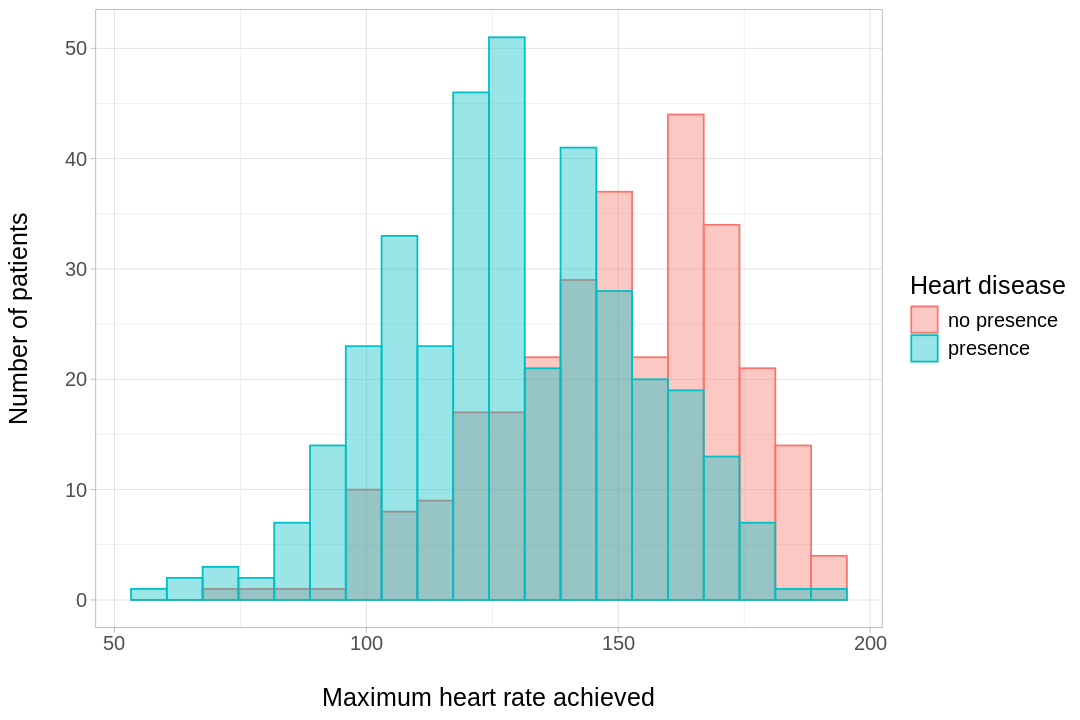

In [41]:
options(repr.plot.width = 9, repr.plot.height = 6)

thalach_histogram <- heart_train |> 
    ggplot(aes(x = thalach, fill = num, colour = num)) +     # setting up the historgam axis and layout 
    geom_histogram(alpha = 0.4, position = "identity", bins = 20) +     # histogram formatting 
    labs(x = "\nMaximum heart rate achieved", y = "Number of patients\n", fill = "Heart disease", colour = "Heart disease") +
    theme_light() +      # visual formatting to allow the bars to be the main focus of the plot - increases readibility and understanding 
    theme(text = element_text(size = 15))

thalach_histogram


### (2) How categorical predictor variables are distributed : exang, ca, and thal

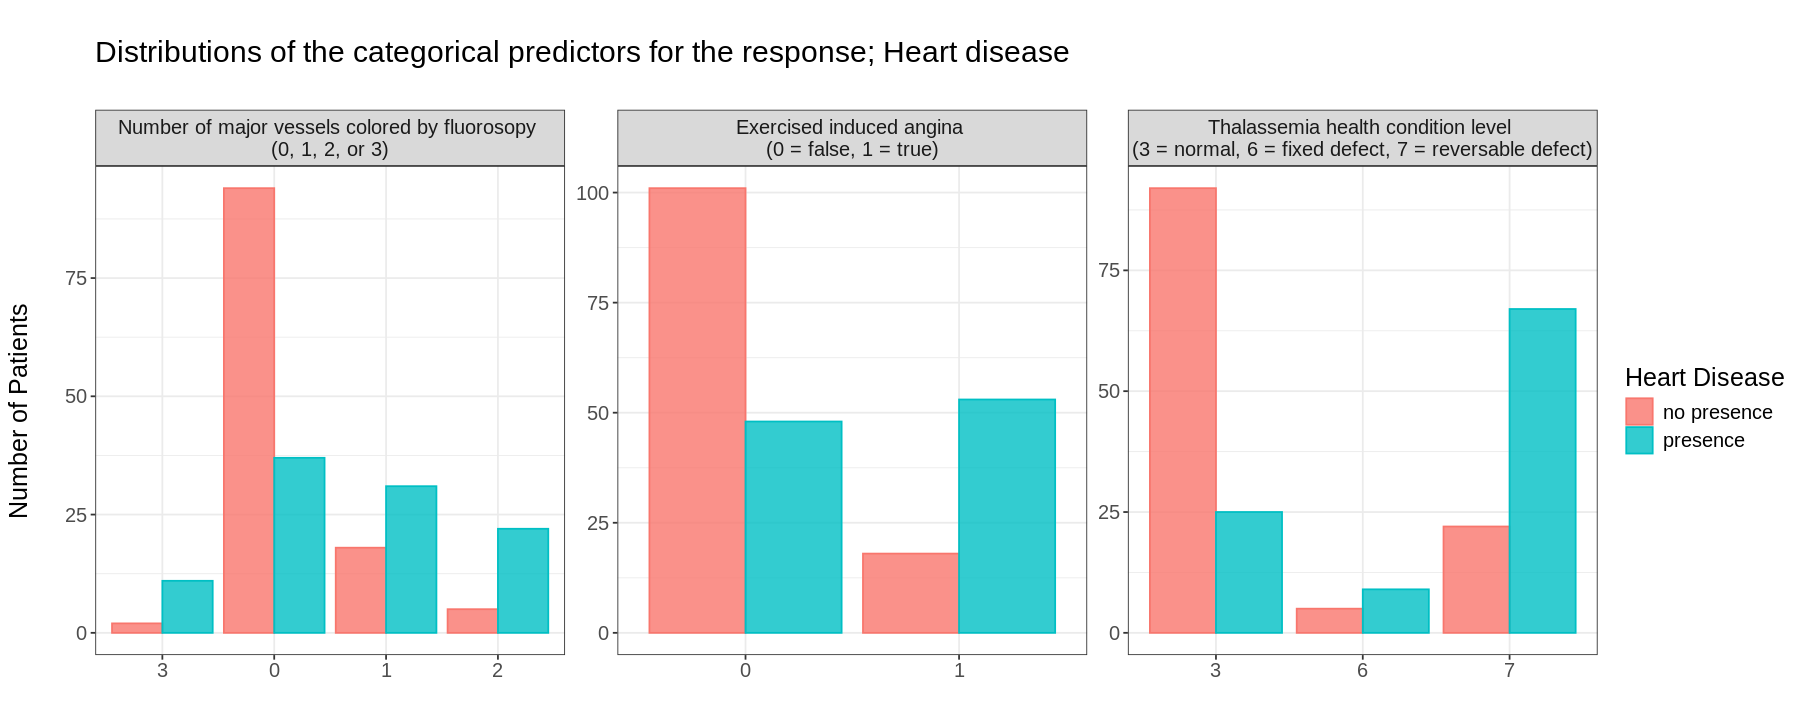

In [42]:

options(repr.plot.width = 15, repr.plot.height = 6)

pivot_data <- heart_train |>
    na.omit() |>     # ommitting NA values to simplify the graph 
    select(num, thal, exang, ca) |>    # selecting the response and predictor variables 
    map_df(as.factor) |>    # turn all of these categorical variables from dbl to factor columns 
    pivot_longer(cols = thal:ca,       # makes the dataset more concise and easier to model with 
                 names_to = "predictors",
                 values_to = "values")

labels <- c(thal = "Thalassemia health condition level \n(3 = normal, 6 = fixed defect, 7 = reversable defect)",
            exang = "Exercised induced angina \n(0 = false, 1 = true)",
            ca = "Number of major vessels colored by fluorosopy \n(0, 1, 2, or 3)")      # formatting the labels of the plot 

facet_categorical_plots <- pivot_data |>    
    ggplot(aes(x = values, fill = num, colour = num)) +
    geom_bar(position = "dodge", stat = "count", alpha = 0.8) +
    labs(x = "",         # label, legend, and axis formatting  
         y = "Number of Patients\n",
         fill = "Heart Disease",
         colour = "Heart Disease",
         title = "\nDistributions of the categorical predictors for the response; Heart disease\n") +
    facet_wrap(vars(predictors), 
               scales = "free",
               labeller = labeller(predictors = labels)) +
    theme_bw() +     
    theme(plot.caption = element_text(hjust = 0),      # plot size formatting 
          text = element_text(size = 15))

facet_categorical_plots


## Expected outcomes and significance of findings: 

Through data wrangling, visualization, and knn-classifcation techniques, I expect to find that patients who have the thalassemia health defect, have high number of major vessels, experience exercise-induced angina, and have low maximum heart rates will likely be diagnosed with or will develop CAD.

By building a classifier that can accurately diagnose patients with CAD, healthcare professionals would be able to identify and diagnose people, implement targetted interventions, and plan personalized treatment plans much more quickly and with greater confidence. This could result in a reduction of CAD-related health problems, and an increase in quality-of-life for patients around the world. 

This data analysis could spark the investigation of more questions, including:
1) Which combinations of factors contribute the most to CAD? 
2) Can the region in which a patient lives in impact the severity of their disease? 


## Bibliography

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. Retrieved June 10, 2024, from https://archive.ics.uci.edu/dataset/45/heart+disease

Mayo Clinic. (2022). Coronary artery disease - Symptoms and causes. Mayo Clinic. Retrieved June 10, 2024, from https://www.mayoclinic.org/diseases-conditions/coronary-artery-disease/symptoms-causes/syc-20350613

Sachdev, P. (2023). Understanding Heart Failure – Diagnosis and Treatment. WebMD. Retrieved June 10, 2024, from https://www.webmd.com/heart-disease/heart-failure/understanding-heart-failure-treatment

Shahjehan, R. D., & Bhutta, B. S. (2023). Coronary Artery Disease. STATPearls. https://pubmed.ncbi.nlm.nih.gov/33231974/

